## Strategy Bonus

#### Karzanov Daniil

##### Task:
Вот вам ещё одна задача на +1 (+2 за крутое исполнение) по прошлой лекции. Надо пойти на яндекс-маркет (или в подобное аналогичное место), выбрать какой-нибудь популярный товар (телефон, стиральная машина, да почти что угодно) и посмотреть разброс цен на него (за строго один и то же товар!). В идеале - выгрузить распределения цен по нескольким товарам и погонять анализом данных. А потом придумать стилизованную модель конкуренции, объясняющую это безобразие.

As the data for our analysis, we download the prices of different cereal brands traded in several European markets in the period from 2013 to 2021. The source:

https://data.europa.eu/data/datasets/cereal_prices?locale=en

Code preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
import warnings
warnings.filterwarnings("ignore")

In [2]:
path_file = "Cereals Prices.csv"
df_raw = pd.read_csv(path_file)

In [3]:
df_raw.head(5)

,Sector Code,Member State Code,Product Group Name,Product Name,Market Name,Product Stage Name,Weight Unit Name,Week - Begin Date,Week - End Date,EU Price
0,NaN,CZ,Barley,Malting barley,Brno,Delivered to processor after one intermediary ...,Tonnes,2013-06-10 00:00:00.000000,2013-06-16 00:00:00.000000,€224.32
1,NaN,CZ,Barley,Malting barley,Brno,Delivered to processor after one intermediary ...,Tonnes,2013-06-17 00:00:00.000000,2013-06-23 00:00:00.000000,€216.72
2,NaN,CZ,Barley,Malting barley,Brno,Delivered to processor after one intermediary ...,Tonnes,2013-07-01 00:00:00.000000,2013-07-07 00:00:00.000000,€214.74
3,NaN,CZ,Barley,Malting barley,Brno,Delivered to processor after one intermediary ...,Tonnes,2013-07-15 00:00:00.000000,2013-07-21 00:00:00.000000,€194.35
4,NaN,CZ,Barley,Malting barley,Brno,Delivered to processor after one intermediary ...,Tonnes,2013-07-29 00:00:00.000000,2013-08-04 00:00:00.000000,€208.54


Transforming and cleaning the dataframe.

In [4]:
df = df_raw[['Product Name', 'Market Name', 'Product Group Name', 'EU Price', 'Week - Begin Date', 'Week - End Date']]
df['EU Price'] = df['EU Price'].apply(lambda x: float(x.replace('€','')))
df['Week - Begin Date'] = df['Week - Begin Date'].apply(pd.to_datetime)
df['Week - End Date'] = df['Week - End Date'].apply(pd.to_datetime)
df['month'] = pd.DatetimeIndex(df['Week - Begin Date']).month
df = df.sort_values(by="Week - Begin Date")
df.index = df['Week - Begin Date']
df = df.rename(columns={"EU Price": "Price"})
df.head(4)

,Product Name,Market Name,Product Group Name,Price,Week - Begin Date,Week - End Date,month
Week - Begin Date,,,,,,,
2009-11-16,Feed barley,Burgas,Barley,92.03,2009-11-16,2009-11-22,11
2009-11-16,Milling wheat,Dobrich,Soft wheat,99.70,2009-11-16,2009-11-22,11
2009-11-16,Feed wheat,Dobrich,Soft wheat,92.03,2009-11-16,2009-11-22,11
2009-11-16,Maize,Pleven,Maize,94.59,2009-11-16,2009-11-22,11


First things first, in a chaotic manner, we conduct data analysis.

### Data Analysis

Let's look at the frequency of entities for each market.

In [5]:
df[['Market Name']].value_counts()

Market Name               
Zachodni                      2954
Vilnius                       2117
Hamburg                       1950
Bologna                       1517
Naantali                      1284
Bratislava                    1279
Slaski                        1251
Lisboa                        1214
Rotterdam                     1177
Antwerpen                      992
Oltenia                        943
Rouen                          923
Dobrich                        898
Ljubljana                      880
Zagreb Depsilo                 858
Kujawsko-Mazurski              843
Wien                           797
UK Average                     796
Praha (Delivered)              721
Constanta                      693
Budapest                       692
Dublin/North East/Midlands     692
Creil                          624
Banat                          556
Pleven                         554
Riga                           525
Muntenia                       475
Burgas                      

As we can see, Zachodni is the most occurring market in the dataframe.

If we look at the summary table corresponding to each brand, we can see that Durum Wheat is the most expensive and most volatile cereal brand among all considered. The least expensive is Rye as its mean and median prices are the lowest. Although Barley had a moderate price, it saw the greatest increase in price over the period.

In [6]:
max_min = lambda x: (x[-1] - x[0])/x[0] 
max_min.__name__ = 'growth'
df.groupby('Product Group Name').agg({"Price": [np.min, np.max, np.mean, np.median, np.std, max_min] }).round(2)

Price                                      
                      amin    amax    mean  median    std growth
Product Group Name                                              
Barley               75.19  330.00  165.62  164.00  31.01   2.37
Durum wheat         188.00  545.00  270.04  250.00  71.51   1.12
Maize                94.59  294.00  169.31  165.88  31.75   1.79
Oats                 71.47  300.00  147.42  140.00  32.56   1.19
Rye                  51.10  281.00  143.60  137.41  29.44   0.74
Soft wheat           72.74  332.00  173.86  170.00  29.35   1.23
Triticale           196.89  261.53  228.31  224.76  25.67   0.33

From the next table, we observe not all the brands are presented in all markets. For example, Oats are available only in Antwerpen, Hamburg, Seinäjoki, Vilnius and Zachodni.

In [7]:
counts = pd.crosstab(df['Product Group Name'], df['Market Name']).T
counts

Product Group Name,Barley,Durum wheat,Maize,Oats,Rye,Soft wheat,Triticale
Market Name,,,,,,,
Antwerpen,254,0,0,236,0,502,0
Banat,0,0,0,0,0,556,0
Bologna,368,374,402,0,0,373,0
Bordeaux,0,0,314,0,0,0,0
Bratislava,271,0,299,0,0,709,0
Brno,69,0,67,0,0,0,0
Brussel - Bruxelles,0,0,387,0,0,0,0
Budapest,144,0,267,0,0,281,0
Burgas,453,0,0,0,0,0,0


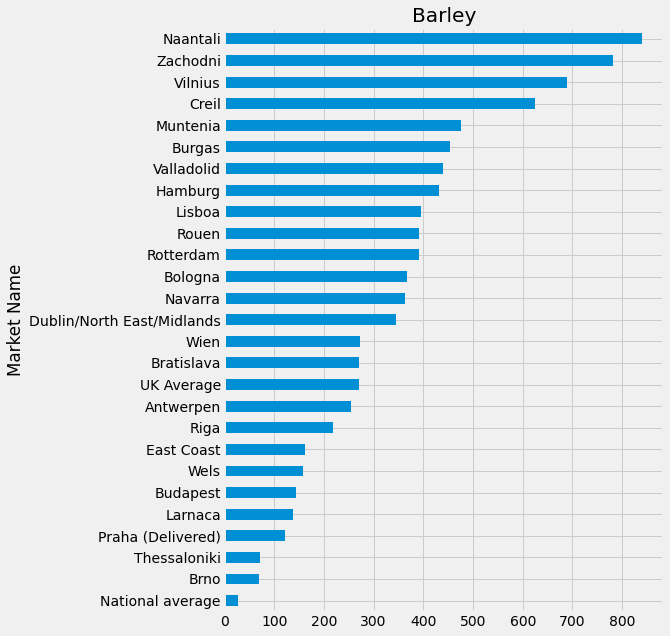

In [8]:
plt.rcParams["figure.figsize"] = (7,10)
counts.Barley[counts.Barley > 0].sort_values().plot(kind='barh');
plt.title("Barley");
plt.plot();

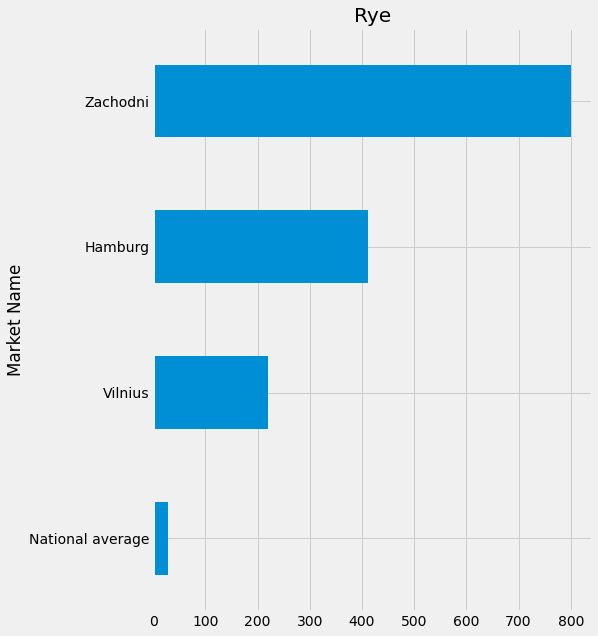

In [9]:
plt.rcParams["figure.figsize"] = (7,10)
counts.Rye[counts.Rye > 0].sort_values().plot(kind='barh');
plt.title("Rye");
plt.plot();

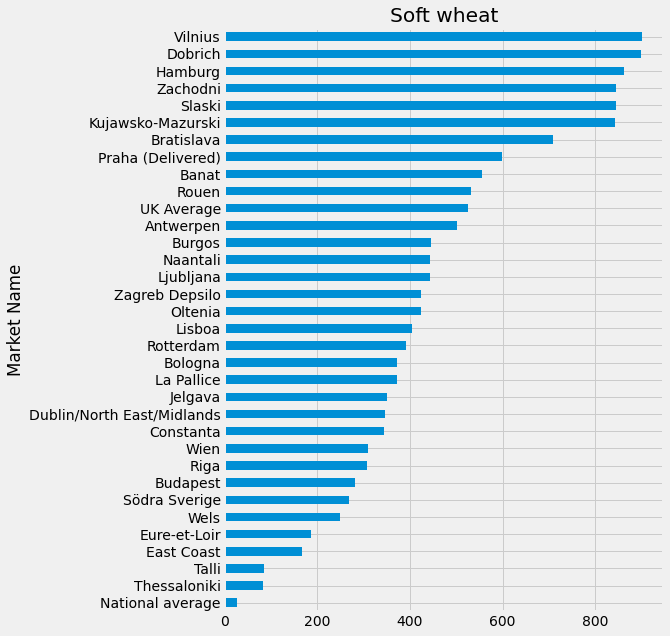

In [10]:
plt.rcParams["figure.figsize"] = (7,10)
counts['Soft wheat'][counts['Soft wheat'] > 0].sort_values().plot(kind='barh');
plt.title("Soft wheat");
plt.plot();

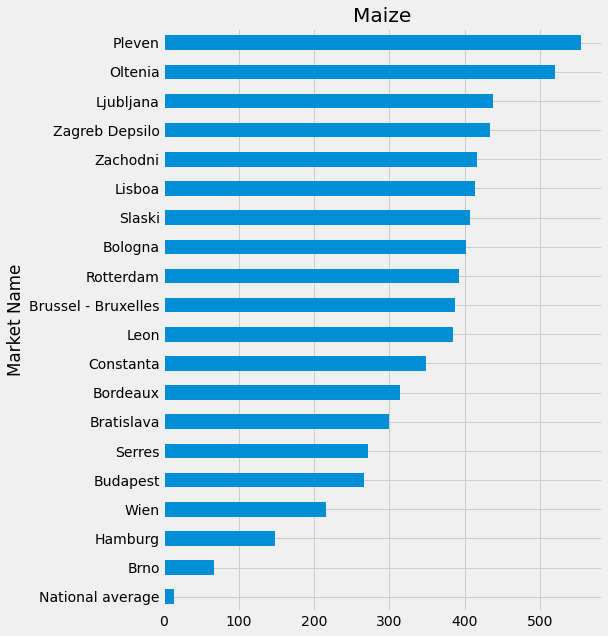

In [11]:
plt.rcParams["figure.figsize"] = (7,10)
counts.Maize[counts.Maize > 0].sort_values().plot(kind='barh');
plt.title("Maize");
plt.plot();

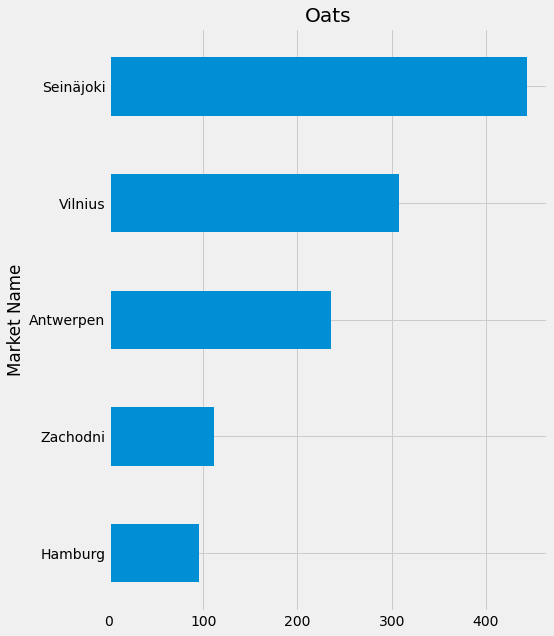

In [12]:
plt.rcParams["figure.figsize"] = (7,10)
counts.Oats[counts.Oats > 0].sort_values().plot(kind='barh');
plt.title("Oats");
plt.plot();

The following table shows the mean price for different brands and different markets. Interestingly, each brand placed various prices in each market it operates, but all brands tried to have a similar price within one market (e.g. Budapest market). Is setting a much higher price than competitors leads to market loss?

In [13]:
means = pd.crosstab(df['Product Group Name'], df['Market Name'], values=df.Price,  aggfunc='mean',
                 margins=True, margins_name="Total").replace(np.nan, 0).round(0).T
means

Product Group Name,Barley,Durum wheat,Maize,Oats,Rye,Soft wheat,Triticale,Total
Market Name,,,,,,,,
Antwerpen,168.0,0.0,0.0,177.0,0.0,179.0,0.0,175.0
Banat,0.0,0.0,0.0,0.0,0.0,165.0,0.0,165.0
Bologna,190.0,274.0,189.0,0.0,0.0,202.0,0.0,213.0
Bordeaux,0.0,0.0,170.0,0.0,0.0,0.0,0.0,170.0
Bratislava,128.0,0.0,143.0,0.0,0.0,150.0,0.0,144.0
Brno,177.0,0.0,152.0,0.0,0.0,0.0,0.0,165.0
Brussel - Bruxelles,0.0,0.0,192.0,0.0,0.0,0.0,0.0,192.0
Budapest,143.0,0.0,157.0,0.0,0.0,150.0,0.0,151.0
Burgas,151.0,0.0,0.0,0.0,0.0,0.0,0.0,151.0


From the following two plots, we start suspecting that the prices for each cereal product fluctuated around its mean throughout the whole period.

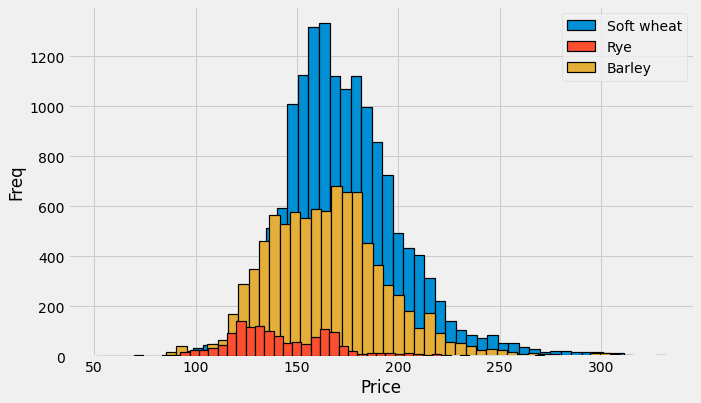

In [14]:
plt.rcParams["figure.figsize"] = (10,6)
df[df['Product Group Name'] == 'Soft wheat'].Price.hist(edgecolor='black', linewidth=1.2, alpha=1, bins=50)
df[df['Product Group Name'] == 'Rye'].Price.hist(edgecolor='black', linewidth=1.2, alpha=1, bins=50, zorder=10)
df[df['Product Group Name'] == 'Barley'].Price.hist(edgecolor='black', linewidth=1.2, alpha=1, bins=50)
plt.legend(['Soft wheat', 'Rye', 'Barley'])
plt.xlabel('Price')
plt.ylabel('Freq')
plt.plot();

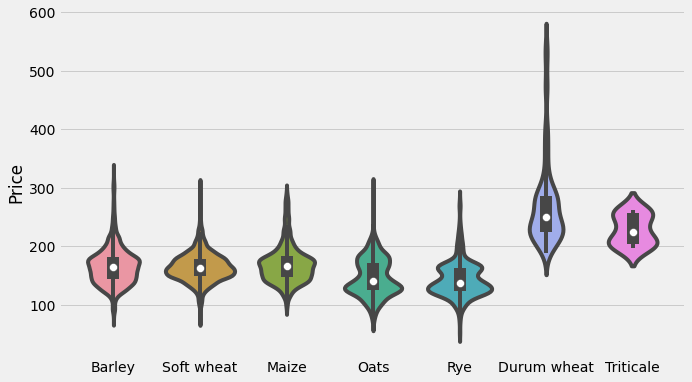

In [15]:
vildf = pd.DataFrame()
for brand in df['Product Group Name'].unique():
    vildf[brand] = pd.Series(df[df['Product Group Name'] == brand]['Price'].values)
sns.violinplot(data=vildf)
plt.ylabel("Price")
plt.plot();

We move further, and now we want to study the presence of seasonality in our data.

The plot below illustrates the mean price of each brand in each month. All in all, the price seems not to depend on the month of sales. The same can be said about total sales.

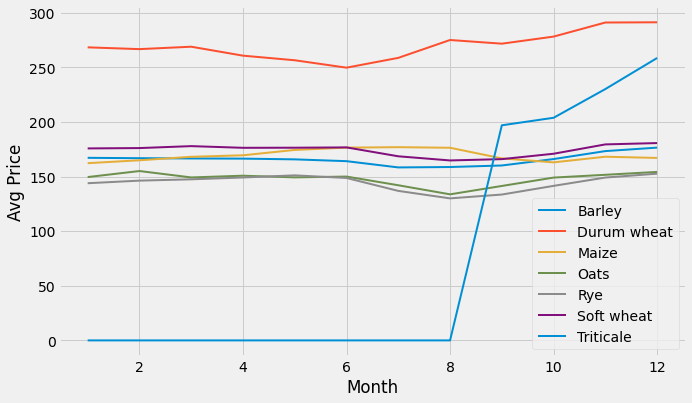

In [16]:
plt.rcParams["figure.figsize"] = (10,6)
tab = pd.crosstab(df['month'], df['Product Group Name'], values=df.Price,  aggfunc='mean').round(2).replace(np.nan, 0)
for col in tab.columns:
    tab[col].plot(lw=2)
plt.legend(tab.columns)
plt.xlabel("Month")
plt.ylabel("Avg Price")
plt.show();

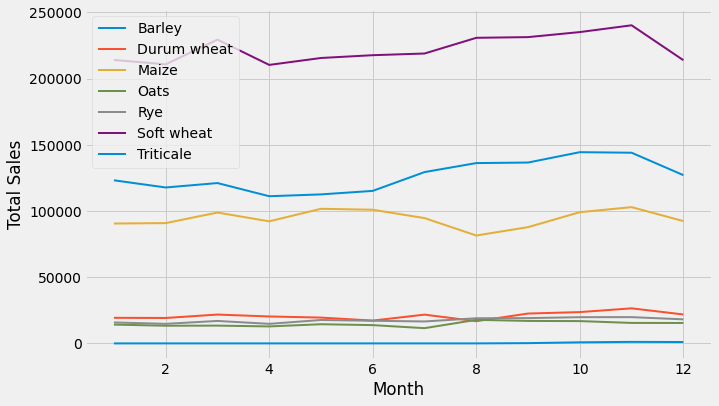

In [17]:
plt.rcParams["figure.figsize"] = (10,6)
tab = pd.crosstab(df['month'], df['Product Group Name'], values=df.Price,  aggfunc='sum').round(2).replace(np.nan, 0)
for col in tab.columns:
    tab[col].plot(lw=2)
plt.legend(tab.columns)
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.show();

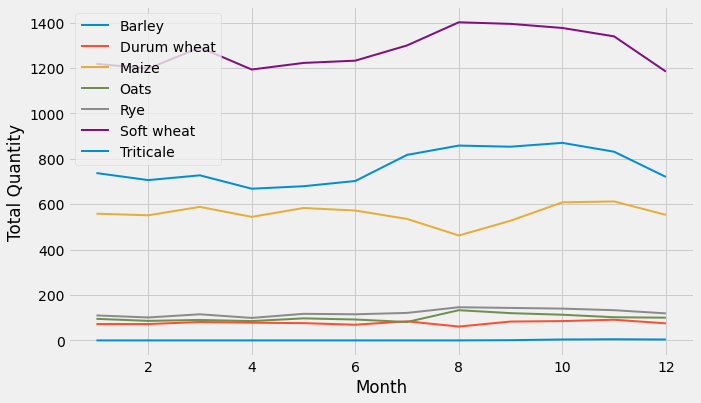

In [18]:
plt.rcParams["figure.figsize"] = (10,6)
tab = pd.crosstab(df['month'], df['Product Group Name'], values=df.Price,  aggfunc='count').round(2).replace(np.nan, 0)
for col in tab.columns:
    tab[col].plot(lw=2)
plt.legend(tab.columns)
plt.xlabel("Month")
plt.ylabel("Total Quantity")
plt.show();

Consider Vilnius market

In [19]:
df_vil = df[df['Market Name']=='Vilnius']
df_vil.head(4)

,Product Name,Market Name,Product Group Name,Price,Week - Begin Date,Week - End Date,month
Week - Begin Date,,,,,,,
2012-10-01,Malting barley,Vilnius,Barley,214.66,2012-10-01,2012-10-07,10
2012-10-01,Feed oats,Vilnius,Oats,128.66,2012-10-01,2012-10-07,10
2012-10-01,Feed barley,Vilnius,Barley,189.19,2012-10-01,2012-10-07,10
2012-10-01,Feed rye,Vilnius,Rye,158.09,2012-10-01,2012-10-07,10


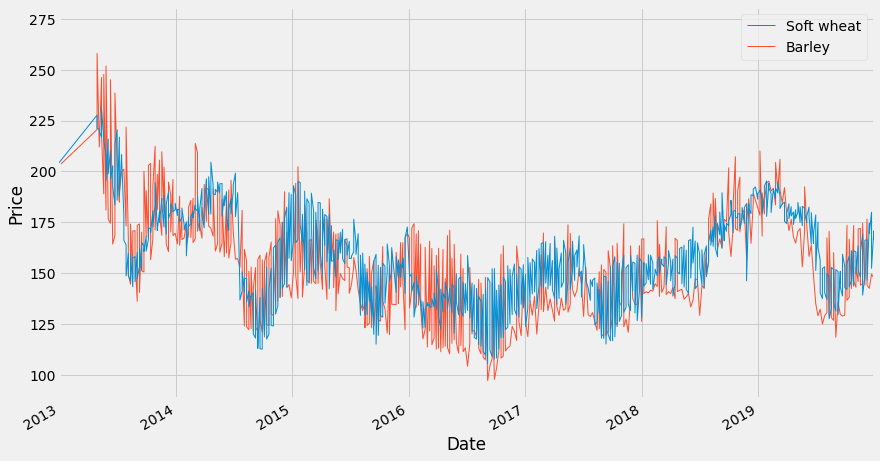

In [20]:
plt.rcParams["figure.figsize"] = (13,8)
df_vil[df_vil['Product Group Name'] == 'Soft wheat'].Price.plot(lw=1, zorder=10);
df_vil[df_vil['Product Group Name'] == 'Barley'].Price.plot(lw=1);


plt.legend(['Soft wheat',  'Barley', ])
plt.xlim('2013-01-01', '2019-12-30')
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot();


As we can see, the price changes are almost the same for the two brands. Is one of the firms afraid of setting the price higher than competitors' price?

We can consider many various cases, however, the Zachodni market seems one of the most interesting. Let study the price fluctuations within this market.

In [21]:
df[df['Market Name']=='Zachodni']['Product Group Name'].value_counts()

Soft wheat    845
Rye           800
Barley        782
Maize         416
Oats          111
Name: Product Group Name, dtype: int64

In [22]:
df_zach = df[df['Market Name']=='Zachodni'] #### Zachodni
df_zach.head(4)

,Product Name,Market Name,Product Group Name,Price,Week - Begin Date,Week - End Date,month
Week - Begin Date,,,,,,,
2013-05-27,Milling wheat,Zachodni,Soft wheat,210.35,2013-05-27,2013-06-02,5
2013-05-27,Feed barley,Zachodni,Barley,182.69,2013-05-27,2013-06-02,5
2013-05-27,Feed rye,Zachodni,Rye,160.02,2013-05-27,2013-06-02,5
2013-05-27,Feed oats,Zachodni,Oats,138.75,2013-05-27,2013-06-02,5


In [23]:
df_zach.groupby('Product Group Name').agg({"Price": [np.min, np.max, np.mean, np.median, np.std, max_min] }).round(2)

Price                                      
                      amin    amax    mean  median    std growth
Product Group Name                                              
Barley              116.54  232.53  164.56  162.46  21.56  -0.06
Maize               128.26  234.93  163.91  161.16  19.35   0.12
Oats                 84.04  192.27  127.04  123.97  23.98   0.02
Rye                  95.92  184.43  135.08  130.87  17.55   0.11
Soft wheat          136.07  226.24  174.32  171.06  18.12  -0.01

Here we show three interesting dependencies for our model.

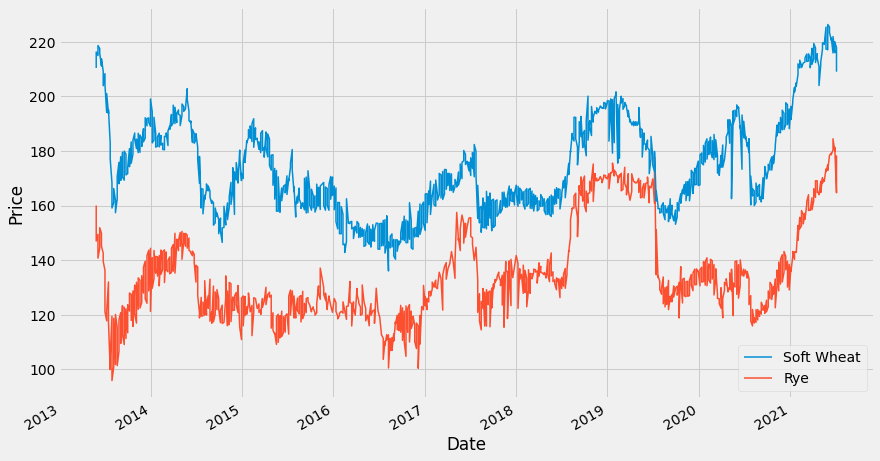

In [24]:
plt.rcParams["figure.figsize"] = (13,8)
df_zach[df_zach['Product Group Name'] == 'Soft wheat'].Price.plot(lw=1.5, zorder=10);
df_zach[df_zach['Product Group Name'] == 'Rye'].Price.plot(lw=1.5);

plt.legend(['Soft Wheat',  'Rye'])
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot();


## Modeling

#### Case 1 - Soft wheat vs Barley in Vilnius

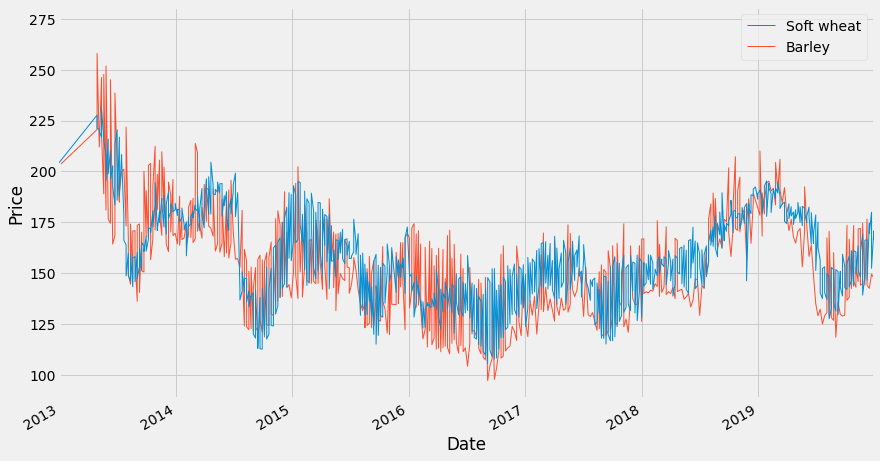

In [25]:
plt.rcParams["figure.figsize"] = (13,8)
df_vil[df_vil['Product Group Name'] == 'Soft wheat'].Price.plot(lw=1, zorder=10);
df_vil[df_vil['Product Group Name'] == 'Barley'].Price.plot(lw=1);


plt.legend(['Soft wheat',  'Barley', ])
plt.xlim('2013-01-01', '2019-12-30')
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot();

Consider the price changes in the Vilnius market. Here, Soft Wheat and Barley are the strongest players. Although there are fewer points for Soft Wheat, we can easily see that the prices fluctuated similarly and were approximately the same. We may assume that both firms produce similar goods and consumers in Vilnius do not differentiate the product. However, we assume that consumers have preference memory, so they are **slightly** more inclined to buy the good they purchased before unless it is much more expensive than the alternative.
At each timestep $t$, Soft Wheat and Barley choose the prices and if one firm sets extremely high prices, it loses the whole market. Most of these assumptions are satisfied by the Bertrand model.

Bertrand model assumes some costs of the unit production $c$. The firm having lower marginal costs pushes the opponent from the market. Since both firms have been operating in the Vilnius market and producing non-zero quantities, we conclude that the firms had similar costs of production.

Now, we need to somehow explain the change in prices over time. This phenomenon will be explained by the fluctuating cost of grains during different years and times of the year. During a fertile period, we expected that the costs are lower, so we see a drop in the price of Soft Wheat and Barley. If the period is not fertile, this is reflected in the marginal costs.

In other words, we model the price choice by a repeated game where the costs are defined by the nature. Each round represents a modified Bertrand competition where minor product differentiation is based on the previous purchases, which explains some slight differences in price at some periods.

$$ price_t =MC_t + \gamma_t  \text{ where } \gamma^i_t  \text{ is the margin tolerated by the i-th customer who have previously consumed the good}$$

$$ MC_t = MC + \epsilon_t \text{ where } \epsilon_t \text{ is defined by the nature}$$ 

#### Case 2 - Soft wheat vs Rye in Zachodni

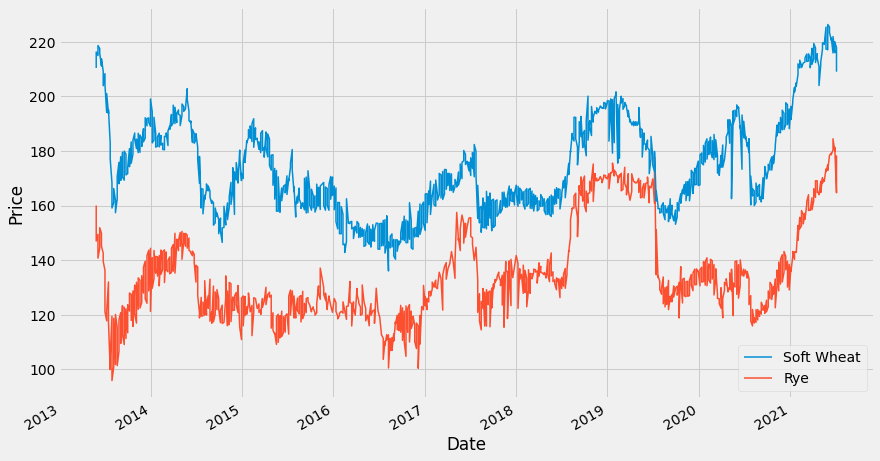

In [26]:
plt.rcParams["figure.figsize"] = (13,8)
df_zach[df_zach['Product Group Name'] == 'Soft wheat'].Price.plot(lw=1.5, zorder=10);
df_zach[df_zach['Product Group Name'] == 'Rye'].Price.plot(lw=1.5);

plt.legend(['Soft Wheat',  'Rye'])
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot();

In [27]:
diff = df_zach[df_zach['Product Group Name'] == 'Soft wheat'].Price - df_zach[df_zach['Product Group Name'] == 'Rye'].Price
np.mean(diff)

39.67362327909887

Another case we consider is the Soft Wheat and Rye competition in the Zachodni market. Here, we, unfortunately, are not able to use the simplest Bertrand model as Soft Wheat visibly sets a much higher price throughout the whole period. However, the main observation we can make here is the fact that the shape of Rye's price time series almost completely replicates Soft Wheat's but it is lower by around 40 euro.

We understand that Soft Wheat production is treated as of higher quality by the Zachodni consumers. Though changing, people are more satisfied by the Soft Wheat unless its price does not exceed Rye's by 40 euro on average. 

We may try to apply a Hotelling model here and modify it to our case. 

Let describe the consumer's utility when purchasing Soft Wheat

$$  U(Soft Wheat)(p_{S}, p_{R}) = [S_{max}  - d \cdot p_{S}  -   g(p_{S} - p_{R})] *I(p_{S} - p_{R} <40)$$

where $S_{max}$ is the maximal level of satisfaction from consuming SW, $g$ is some increasing function of the difference between Soft Wheat's price and Rye's price. If the price difference is too high then it does not make the individual happy to consume SW. Assume that $d$ is a constant and the increase of price by a euro usually decreases the utility by $d$.

Here, we apply the assumption of the simplified version of the Hotelling model, where we assume that all customers cannot avoid consuming.

Do the same for Rye

$$  U(Rye)(p_{S}, p_{R}) = [\tilde S_{max}  - \tilde d \cdot p_{R} ]$$

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e17cb2ce-04ec-44ce-a16e-64fa96d98fe3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>